In [1]:
import numpy as np
import utils_analysis as uta
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [2]:
def get_asym_training_data(dimension, modes, asym):
    data = np.load(f"data_input/dim_{dimension}_modes_{modes}_{asym}.npy", allow_pickle=True)
    return data

def FE_hist_mod(data, bounds, binw=0.1, binner=None):

    if binner is None:
        binner = (np.arange(bounds[0], bounds[1] + binw, binw),
                    np.arange(bounds[2], bounds[3] + binw, binw))

    counts, xedges, yedges = np.histogram2d(data[:,0], data[:,1],
                                           bins=binner, density=True)
    prob = counts + 1e-3
    G = -np.log(prob)
    G[G == np.inf] = -1
    G[G == -1] = max(G.ravel())
    G -= min(G.ravel())
    return G, prob, xedges, yedges

def delta_from_hist(G, prob, xe, ye, split, cutoff):
    split_ind = int(split * G.shape[0])
    G_split1 = G[:split_ind, :]
    G_split2 = G[split_ind:, :]
    prob_split1 = prob[:split_ind, :]
    prob_split2 = prob[split_ind:, :]
    Z1 = np.sum(prob_split1 * np.where(G_split1 < cutoff, 1, 0))
    Z2 = np.sum(prob_split2 * np.where(G_split2 < cutoff, 1, 0))
    delta = np.abs(np.log(Z1) - np.log(Z2))
    return delta

def delta_models(asym, split, iter, cutoff):
    
    display_keyword = f'{asym}_varyingasym_{iter}'
    training_data = get_asym_training_data(display_dim, display_modes, asym)
    
    training_length = training_data.shape[0]
    ns_generated_data = uta.get_data('ns', display_dim, display_modes, display_keyword)
    cfm_generated_data = uta.get_data('cfm', display_dim, display_modes, display_keyword)
    ddpm_generated_data = uta.get_data('ddpm', display_dim, display_modes, display_keyword)

    generated_length = ns_generated_data.shape[0]
    pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
    training_pca = pca.fit_transform(training_data)
    ns_generated_pca = pca.transform(ns_generated_data)
    cfm_generated_pca = pca.transform(cfm_generated_data)
    ddpm_generated_pca = pca.transform(ddpm_generated_data)

    restrict = min(training_length, generated_length)

    G_MD, prob_MD, xe_MD, ye_MD = FE_hist_mod(training_pca[:restrict], bounds, binw=0.3)
    G_NS, prob_NS, xe_NS, ye_NS = FE_hist_mod(ns_generated_pca[:restrict], bounds, binw=0.3)
    G_CFM, prob_CFM, xe_CFM, ye_CFM = FE_hist_mod(cfm_generated_pca[:restrict], bounds, binw=0.3)
    G_DDPM, prob_DDPM, xe_DDPM, ye_DDPM = FE_hist_mod(ddpm_generated_pca[:restrict], bounds, binw=0.3)

    delta_arr = np.array([])

    delta_MD = delta_from_hist(G_MD, prob_MD, xe_MD, ye_MD, split, cutoff)
    delta_NS = delta_from_hist(G_NS, prob_NS, xe_NS, ye_NS, split, cutoff)
    delta_CFM = delta_from_hist(G_CFM, prob_CFM, xe_CFM, ye_CFM, split, cutoff)
    delta_DDPM = delta_from_hist(G_DDPM, prob_DDPM, xe_DDPM, ye_DDPM, split, cutoff)

    delta_arr = np.append(delta_arr, delta_MD)
    delta_arr = np.append(delta_arr, delta_NS)
    delta_arr = np.append(delta_arr, delta_CFM)
    delta_arr = np.append(delta_arr, delta_DDPM)
    
    return delta_arr

In [3]:
display_dim = 50
display_modes = 2
bounds = np.array([-12, 12, -12, 12])

#asym_array = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
asym_array = np.array([4, 5, 6, 7, 8, 9, 10])
#asym_range = np.array([0.1, 0.5, 1, 2.5, 5, 10, 15, 25, 35, 50])
asym_range = np.array([2.5, 5, 10, 15, 25, 35, 50])
#split_array = np.array([0.75, 0.725, 0.7, 0.685, 0.675, 0.65, 0.6, 0.575, 0.5, 0.5])
split_array = np.array([0.685, 0.675, 0.65, 0.6, 0.575, 0.5, 0.5])

ind = 0
test_iter = 1
test_asym = asym_array[ind]
test_asym_val = asym_range[ind]
test_split_val = split_array[ind]

In [4]:
display_keyword = f'{test_asym}_varyingasym_{test_iter}'
training_data = get_asym_training_data(display_dim, display_modes, test_asym)
training_length = training_data.shape[0]
ns_generated_data = uta.get_data('ns', display_dim, display_modes, display_keyword)
cfm_generated_data = uta.get_data('cfm', display_dim, display_modes, display_keyword)
ddpm_generated_data = uta.get_data('ddpm', display_dim, display_modes, display_keyword)
generated_length = ns_generated_data.shape[0]

pca = PCA(n_components=2)
training_pca = pca.fit_transform(training_data)
ns_generated_pca = pca.transform(ns_generated_data)
cfm_generated_pca = pca.transform(cfm_generated_data)
ddpm_generated_pca = pca.transform(ddpm_generated_data)
restrict = min(training_length, generated_length)

G_MD, prob_MD, xe_MD, ye_MD = FE_hist_mod(training_pca[:restrict], bounds, binw=0.3)
G_NS, prob_NS, xe_NS, ye_NS = FE_hist_mod(ns_generated_pca[:restrict], bounds, binw=0.3)
G_CFM, prob_CFM, xe_CFM, ye_CFM = FE_hist_mod(cfm_generated_pca[:restrict], bounds, binw=0.3)
G_DDPM, prob_DDPM, xe_DDPM, ye_DDPM = FE_hist_mod(ddpm_generated_pca[:restrict], bounds, binw=0.3)

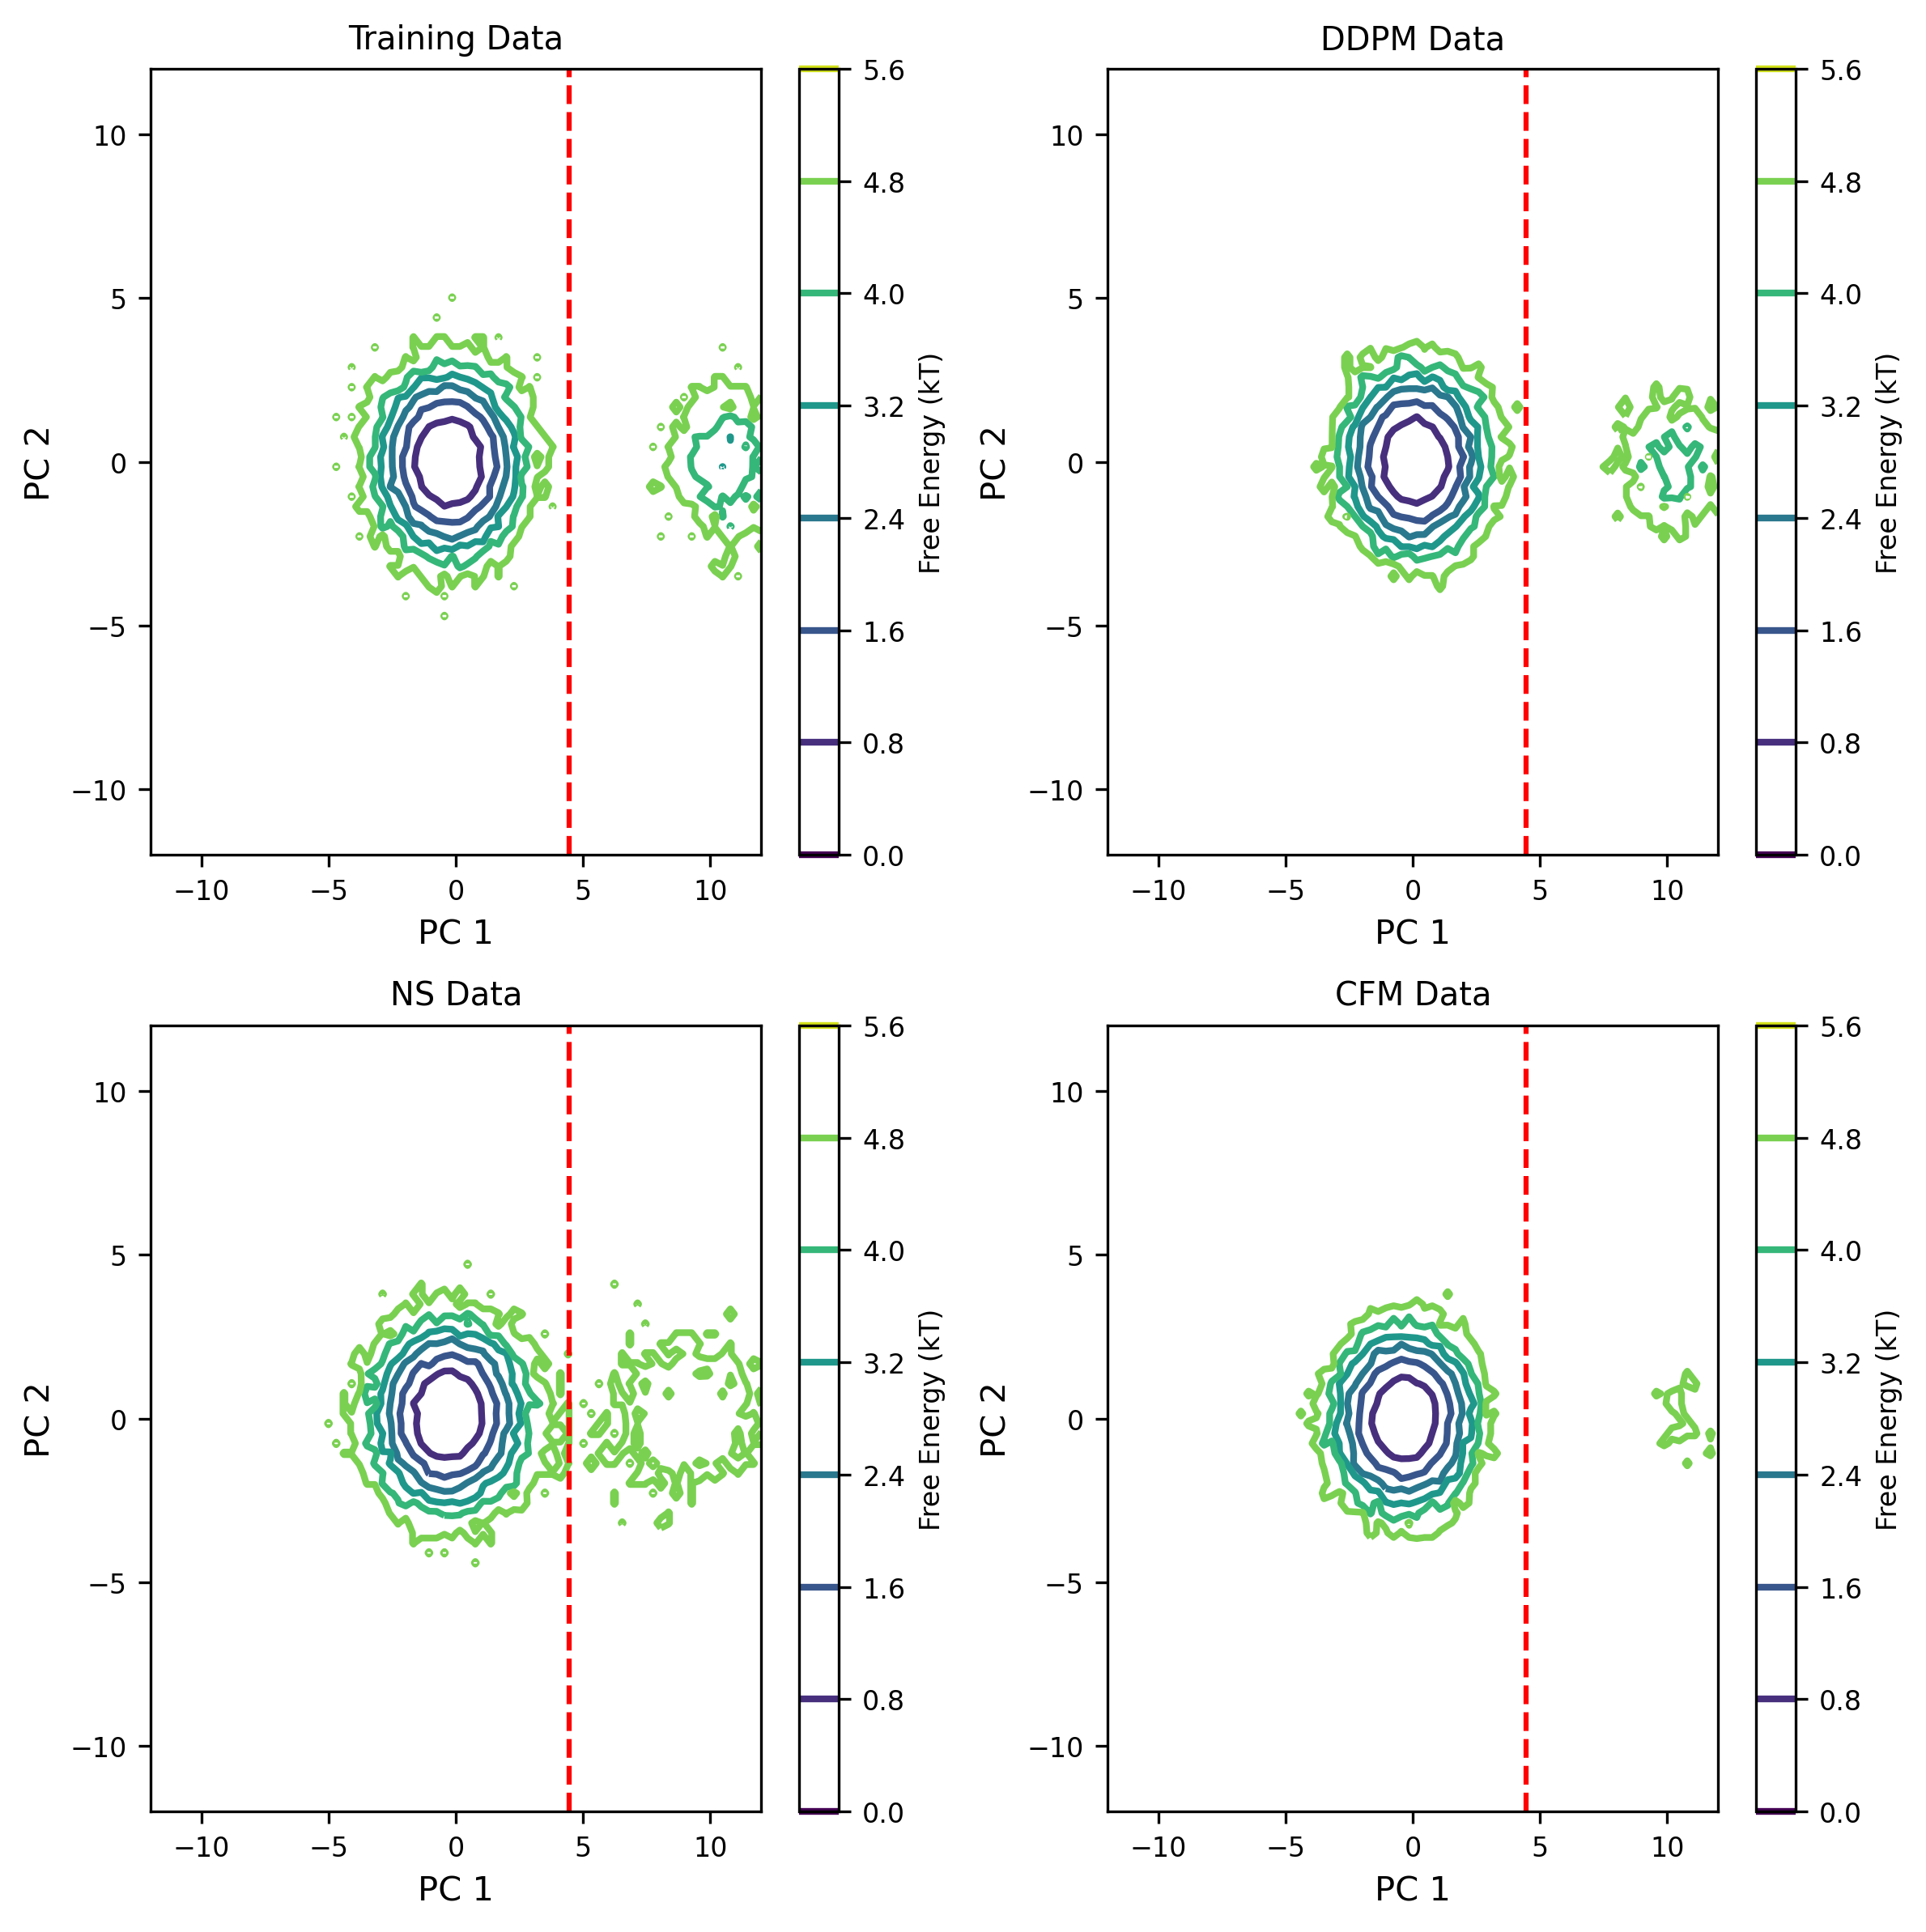

In [5]:
fig, axs = plt.subplots(2,2, figsize=(8,8), dpi=300, tight_layout=False)
plt.rcParams.update({'font.size': 8})
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

line_val = bounds[0] + (bounds[1] - bounds[0]) * test_split_val

contour_MD = axs[0][0].contour(G_MD.T, extent=[xe_MD[0], xe_MD[-1], ye_MD[0], ye_MD[-1]],
                               linewidths=2, vmin=0, vmax=6)
contour_DDPM = axs[0][1].contour(G_DDPM.T, extent=[xe_DDPM[0], xe_DDPM[-1], ye_DDPM[0], ye_DDPM[-1]],
                                  linewidths=2, vmin=0, vmax=6)
contour_NS = axs[1][0].contour(G_NS.T, extent=[xe_NS[0], xe_NS[-1], ye_NS[0], ye_NS[-1]],
                                linewidths=2, vmin=0, vmax=6)
contour_CFM = axs[1][1].contour(G_CFM.T, extent=[xe_CFM[0], xe_CFM[-1], ye_CFM[0], ye_CFM[-1]],
                                 linewidths=2, vmin=0, vmax=6)

fig.colorbar(contour_MD, ax=axs[0][0], orientation='vertical', label='Free Energy (kT)')
fig.colorbar(contour_DDPM, ax=axs[0][1], orientation='vertical', label='Free Energy (kT)')
fig.colorbar(contour_NS, ax=axs[1][0], orientation='vertical', label='Free Energy (kT)')
fig.colorbar(contour_CFM, ax=axs[1][1], orientation='vertical', label='Free Energy (kT)')

axs[0][0].axvline(x=line_val, color='red', linestyle='--')
axs[0][1].axvline(x=line_val, color='red', linestyle='--')
axs[1][0].axvline(x=line_val, color='red', linestyle='--')
axs[1][1].axvline(x=line_val, color='red', linestyle='--')

axs[0][0].set_xlabel("PC 1")
axs[0][0].set_ylabel("PC 2")
axs[0][0].set_title("Training Data")
axs[0][1].set_xlabel("PC 1")
axs[0][1].set_ylabel("PC 2")
axs[0][1].set_title("DDPM Data")
axs[1][0].set_xlabel("PC 1")
axs[1][0].set_ylabel("PC 2")
axs[1][0].set_title("NS Data")
axs[1][1].set_xlabel("PC 1")
axs[1][1].set_ylabel("PC 2")
axs[1][1].set_title("CFM Data")

axs[0][0].set_xlim(bounds[0], bounds[1])
axs[0][0].set_ylim(bounds[2], bounds[3])
axs[0][1].set_xlim(bounds[0], bounds[1])
axs[0][1].set_ylim(bounds[2], bounds[3])

plt.show()

/tmp/ipykernel_2999972/2564549116.py:28: RuntimeWarning: divide by zero encountered in log
  delta = np.abs(np.log(Z1) - np.log(Z2))


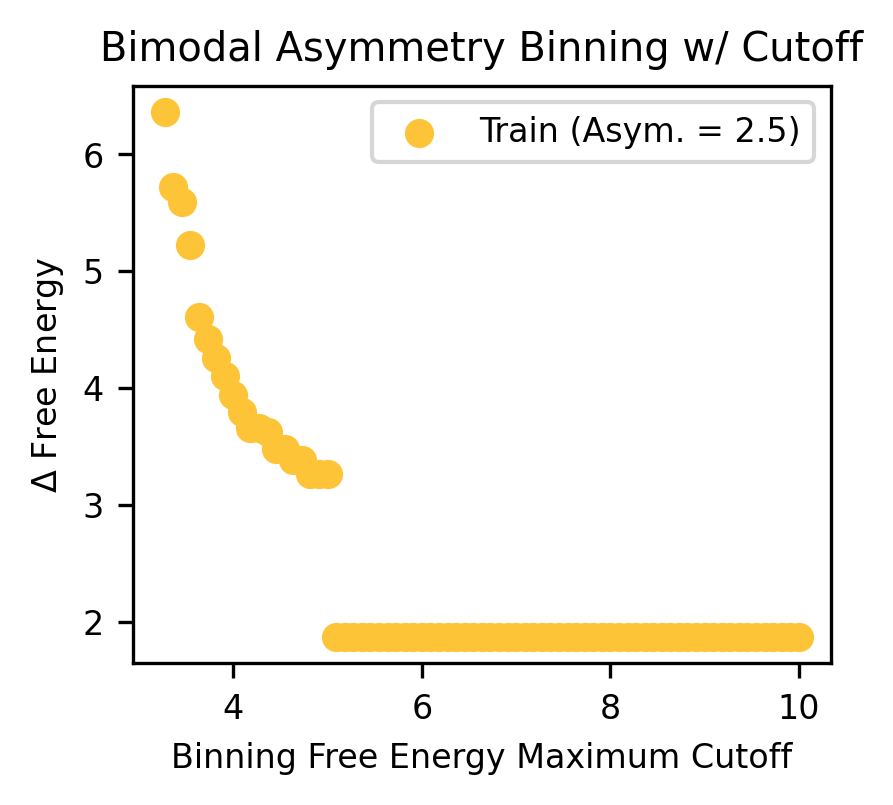

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(3, 2.5))

cutoff_range = np.linspace(1, 10, 100)
delta_array = np.array([])
for i in cutoff_range:
    delta_array = np.append(delta_array, delta_from_hist(G_MD, prob_MD, xe_MD, ye_MD, test_split_val, i))

plt.scatter(cutoff_range, delta_array, label=f"Train (Asym. = {test_asym_val})", color='#fec438')

plt.xlabel('Binning Free Energy Maximum Cutoff')
plt.ylabel(f"$\Delta$ Free Energy")
plt.title('Bimodal Asymmetry Binning w/ Cutoff')

plt.legend()

plt.show()

In [7]:
current_cutoff = 4.5

In [8]:
delta_from_hist(G_MD, prob_MD, xe_MD, ye_MD, test_split_val, current_cutoff)

3.4781000933126043

In [9]:
cutoff = 4.5

final_arr_1 = np.zeros((7, 4))
for i in np.arange(7):
    final_arr_1[i] = delta_models(asym_array[i], split_array[i], 1, cutoff)

final_arr_2 = np.zeros((7, 4))
for i in np.arange(7):
    final_arr_2[i] = delta_models(asym_array[i], split_array[i], 1, cutoff)

final_arr_3 = np.zeros((7, 4))
for i in np.arange(7):
    final_arr_3[i] = delta_models(asym_array[i], split_array[i], 1, cutoff)

train_fed_1 = final_arr_1[:,0]
train_fed_2 = final_arr_2[:,0]
train_fed_3 = final_arr_3[:,0]

ns_fed_1 = final_arr_1[:,1]
ns_fed_2 = final_arr_2[:,1]
ns_fed_3 = final_arr_3[:,1]

cfm_fed_1 = final_arr_1[:,2]
cfm_fed_2 = final_arr_2[:,2]
cfm_fed_3 = final_arr_3[:,2]

ddpm_fed_1 = final_arr_1[:,3]
ddpm_fed_2 = final_arr_2[:,3]
ddpm_fed_3 = final_arr_3[:,3]

train_fed_all_arrays = np.array([train_fed_1, train_fed_2, train_fed_3])
ns_fed_all_arrays = np.array([ns_fed_1, ns_fed_2, ns_fed_3])
cfm_fed_all_arrays = np.array([cfm_fed_1, cfm_fed_2, cfm_fed_3])
ddpm_fed_all_arrays = np.array([ddpm_fed_1, ddpm_fed_2, ddpm_fed_3])

In [10]:
ns_mean_fed = np.mean(ns_fed_all_arrays, axis=0)
ns_std_fed = np.std(ns_fed_all_arrays, axis=0)

cfm_mean_fed = np.mean(cfm_fed_all_arrays, axis=0)
cfm_std_fed = np.std(cfm_fed_all_arrays, axis=0)

ddpm_mean_fed = np.mean(ddpm_fed_all_arrays, axis=0)
ddpm_std_fed = np.std(ddpm_fed_all_arrays, axis=0)

train_mean_fed = np.mean(train_fed_all_arrays, axis=0)
train_std_fed = np.std(train_fed_all_arrays, axis=0)

ns_ss_res = np.sum((ns_fed_all_arrays - train_fed_all_arrays) ** 2)
ns_ss_tot = np.sum((ns_fed_all_arrays - np.mean(ns_fed_all_arrays)) ** 2)

cfm_ss_res = np.sum((cfm_fed_all_arrays - train_fed_all_arrays) ** 2)
cfm_ss_tot = np.sum((cfm_fed_all_arrays - np.mean(cfm_fed_all_arrays)) ** 2)

ddpm_ss_res = np.sum((ddpm_fed_all_arrays - train_fed_all_arrays) ** 2)
ddpm_ss_tot = np.sum((ddpm_fed_all_arrays - np.mean(ddpm_fed_all_arrays)) ** 2)

ns_rsq = 1 - ns_ss_res/ns_ss_tot
cfm_rsq = 1 - cfm_ss_res/cfm_ss_tot
ddpm_rsq = 1 - ddpm_ss_res/ddpm_ss_tot

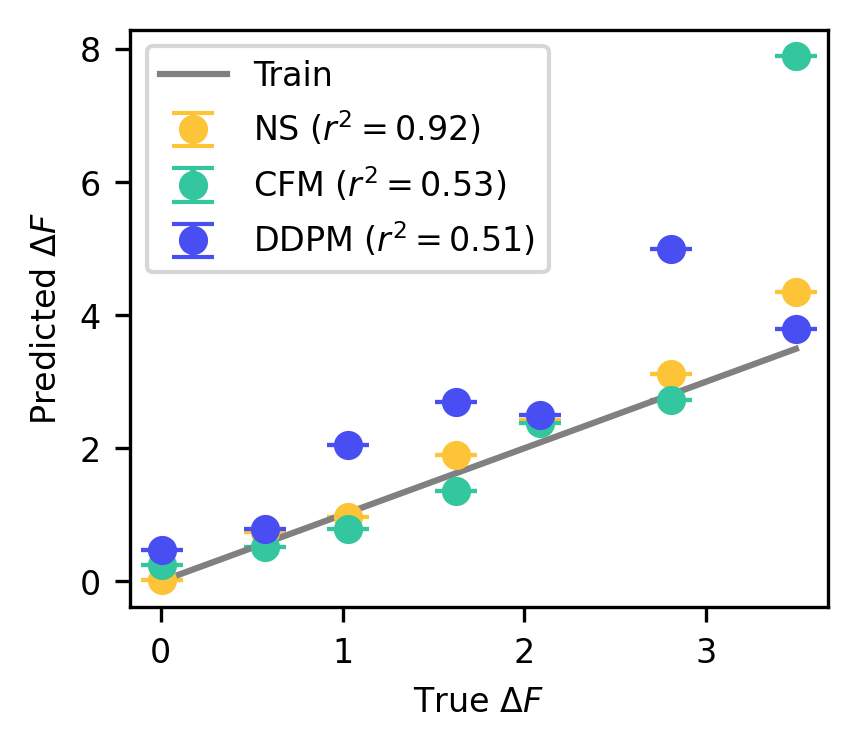

In [25]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(3, 2.5))

plt.errorbar(train_mean_fed, ns_mean_fed, yerr = ns_std_fed, fmt='o', capsize=5, label=f"NS ($r^2={ns_rsq:.2f}$)", color='#fec438')
plt.errorbar(train_mean_fed, cfm_mean_fed, yerr = cfm_std_fed, fmt='o', capsize=5, label=f"CFM ($r^2={cfm_rsq:.2f}$)", color='#33c69f')
plt.errorbar(train_mean_fed, ddpm_mean_fed, yerr = ddpm_std_fed, fmt='o', capsize=5, label=f"DDPM ($r^2={ddpm_rsq:.2f}$)", color='#484ef1')
plt.plot(train_mean_fed, train_mean_fed, label='Train', color='gray')

#plt.xlim((0, 6))
#plt.ylim((0, 6))

plt.xlabel(r"True $\Delta F$")
plt.ylabel(r"Predicted $\Delta F$")
#plt.title(f"Asymmetry Comparison (GMM) Cutoff: {cutoff} kT")

plt.legend()

plt.show()

In [24]:
asym_array = np.array([3, 4, 5, 6, 7, 8, 9, 10])
#asym_range = np.array([0.1, 0.5, 1, 2.5, 5, 10, 15, 25, 35, 50])
split_array = np.array([0.75, 0.725, 0.7, 0.685, 0.675, 0.65, 0.6, 0.575, 0.5, 0.5])

In [124]:
def model_ss_res(cutoff):
    
    final_arr_1 = np.zeros((8, 4))
    for i in np.arange(8):
        final_arr_1[i] = delta_models(asym_array[i], split_array[i], 1, cutoff)
        
    final_arr_2 = np.zeros((8, 4))
    for i in np.arange(8):
        final_arr_2[i] = delta_models(asym_array[i], split_array[i], 1, cutoff)

    final_arr_3 = np.zeros((8, 4))
    for i in np.arange(8):
        final_arr_3[i] = delta_models(asym_array[i], split_array[i], 1, cutoff)

    train_fed_1 = final_arr_1[:,0]
    train_fed_2 = final_arr_2[:,0]
    train_fed_3 = final_arr_3[:,0]

    ns_fed_1 = final_arr_1[:,1]
    ns_fed_2 = final_arr_2[:,1]
    ns_fed_3 = final_arr_3[:,1]

    cfm_fed_1 = final_arr_1[:,2]
    cfm_fed_2 = final_arr_2[:,2]
    cfm_fed_3 = final_arr_3[:,2]

    ddpm_fed_1 = final_arr_1[:,3]
    ddpm_fed_2 = final_arr_2[:,3]
    ddpm_fed_3 = final_arr_3[:,3]

    train_fed_all_arrays = np.array([train_fed_1, train_fed_2, train_fed_3])
    ns_fed_all_arrays = np.array([ns_fed_1, ns_fed_2, ns_fed_3])
    cfm_fed_all_arrays = np.array([cfm_fed_1, cfm_fed_2, cfm_fed_3])
    ddpm_fed_all_arrays = np.array([ddpm_fed_1, ddpm_fed_2, ddpm_fed_3])

    train_mean_fed = np.mean(train_fed_all_arrays, axis=0)
    train_std_fed = np.std(train_fed_all_arrays, axis=0)

    ns_ss_res = np.sum((ns_fed_all_arrays - train_fed_all_arrays) ** 2)
    ns_ss_tot = np.sum((ns_fed_all_arrays - np.mean(ns_fed_all_arrays)) ** 2)

    cfm_ss_res = np.sum((cfm_fed_all_arrays - train_fed_all_arrays) ** 2)
    cfm_ss_tot = np.sum((cfm_fed_all_arrays - np.mean(cfm_fed_all_arrays)) ** 2)

    ddpm_ss_res = np.sum((ddpm_fed_all_arrays - train_fed_all_arrays) ** 2)
    ddpm_ss_tot = np.sum((ddpm_fed_all_arrays - np.mean(ddpm_fed_all_arrays)) ** 2)

    return (ns_ss_res, cfm_ss_res, ddpm_ss_res)

In [22]:
cutoff_arr = np.linspace(5, 10, 10)
res_storage = np.array([])
for i in np.arange(len(cutoff_arr)):
    res_storage = np.append(res_storage, model_ss_res(cutoff_arr[i]))

In [23]:
res_storage

array([ 2.55563095, 20.45801078, 52.57152331,  0.24691272,  0.2600556 ,
        1.69247445,  0.24691273,  0.26007719,  1.69249904,  0.24690798,
        0.26014209,  1.69257293,  0.24691435,  0.2600556 ,  1.69247445,
        0.24690954,  0.26012044,  1.69254828,  0.24691109,  0.26007719,
        1.69249904,  0.24690954,  0.26012044,  1.69254828,  0.24691273,
        0.26007719,  1.69249904,  0.24690798,  0.26014209,  1.69257293])

In [28]:
ns_res_arr = res_storage[::3]
cfm_res_arr = res_storage[1::3]
ddpm_res_arr = res_storage[2::3]

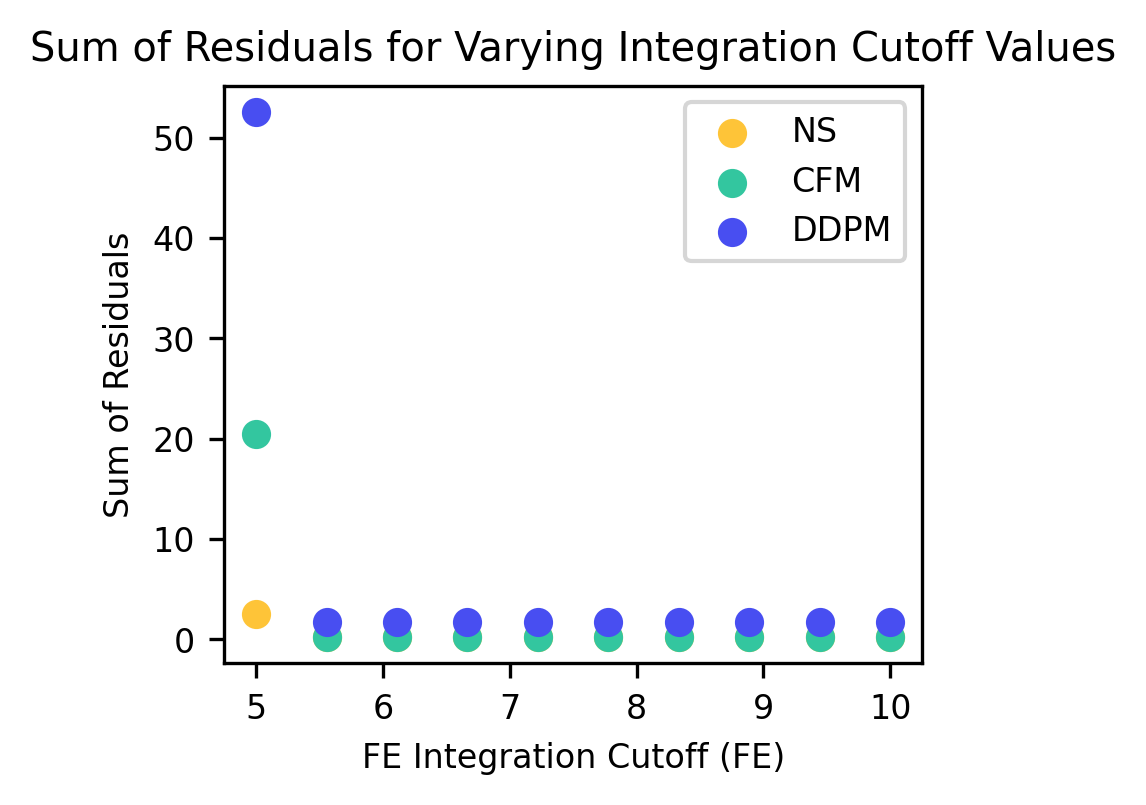

In [30]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(3, 2.5))

plt.scatter(cutoff_arr, ns_res_arr, label="NS", color='#fec438')
plt.scatter(cutoff_arr, cfm_res_arr, label="CFM", color='#33c69f')
plt.scatter(cutoff_arr, ddpm_res_arr, label="DDPM", color='#484ef1')

#plt.xlim((0, 6))
#plt.ylim((0, 6))

plt.xlabel('FE Integration Cutoff (FE)')
plt.ylabel('Sum of Residuals')
plt.title('Sum of Residuals for Varying Integration Cutoff Values')

plt.legend()

plt.show()